In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from binance.spot import Spot
import warnings
import ta
warnings.filterwarnings('ignore')

In [8]:
def market_data(crypto = ['ETHBRL'],interval = '1d',startTime = []):

    spot_client = Spot(base_url="https://api.binance.com")

    df_final = []

    for sym in crypto:
        if len(startTime) == 0:
            prices = spot_client.klines(sym, interval,limit = 1000)
        else:
            prices = spot_client.klines(sym, interval,startTime = startTime[0],limit = 1000)


        df = pd.DataFrame({'symb':sym,'ds':list(zip(*prices))[0],'open':list(zip(*prices))[1],
                  'high':list(zip(*prices))[2],'low':list(zip(*prices))[3],
                  'close':list(zip(*prices))[4],'volume':list(zip(*prices))[5]})

        if len(df_final) == 0:

            df_final = df.copy()

        else:

            df_final = pd.concat([df_final,df])

    df_final['ds'] = pd.to_datetime(df_final['ds'],unit='ms')

    for col in list(df_final.columns[2:]):
        df_final[col] = pd.to_numeric(df_final[col])
    
    print(f'Generating dataframe with {crypto}')
    return df_final

In [17]:
def load_market(crypto=['ETHUSDT'],interval = '1d'):

    data = market_data(crypto = crypto, interval = '1d')
    data = data.drop(columns='symb')
    data['rsi_7'] = ta.momentum.rsi(data['close'], window=7, fillna=False)
    data['ema_9'] = ta.trend.ema_indicator(data['close'],window = 9,fillna=False)
    data['ema_26'] = ta.trend.ema_indicator(data['close'],window = 26,fillna=False)

    return data

In [45]:
def plot_market(data,buys = [],sells = []):
    nrows=1
    ncols=1

    fig,ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(24*ncols,12*nrows))

    graf = data.copy()
    ax2 = ax.twinx()
    sns.lineplot(data=graf,x='ds',y='close',color='red',ax=ax,label='close')

    sns.lineplot(data=graf,x='ds',y='ema_9',color='black',ax=ax,label='ema_9')
    sns.lineplot(data=graf,x='ds',y='ema_26',color='green',ax=ax,label='ema_26')
    #sns.lineplot(data=graf,x='ds',y='rsi_7',color='pink',ax=ax2,label='rsi_7')

    #ax2.axhline(30,c='blue')
    #ax2.axhline(70,c='blue')
    
    if len(buys) > 0:
        for b in buys:
            ax.axvline(b,c = 'green')
            
    if len(sells) > 0:
        for s in sells:
            ax.axvline(s,c = 'red')
            
    ax.legend(loc='upper left')
    #ax2.legend(loc='upper right')
    
    return None

In [50]:
def back_test(data,money_init = 100):
    data['profit'] = 0
    data['profit%'] = 0
    buys_all = []
    sells_all = []

    for i in data.index:
        buys = []
        sells = []
        
        df_temp = data.loc[i:]
        money = money_init
        coins = 0
        
        df_temp['status'] = np.where((df_temp['ema_9'] > df_temp['ema_26']) & (df_temp['rsi_7'] < 80),
                                     'BUY','SELL')
 
        for j in df_temp.index:
            
            if (((df_temp.loc[j,'status']) == 'BUY')&(money > 0)):
                coins = (money/df_temp.loc[j,'close'])*0.999 #taxa Binance
                money_temp = money
                money = 0
                buys.append(df_temp.loc[j,'ds'])
                

            elif (((df_temp.loc[j,'status']) == 'SELL')&(coins > 0)):
                money = (df_temp.loc[j,'close'] * coins)*0.999 #taxa Binance
                coins = 0

                sells.append(df_temp.loc[j,'ds'])
            

        if money == 0: 
            money = df_temp.loc[j,'close'] * coins

        data.loc[i,'gross'] = money
        data.loc[i,'profit'] = money - money_init
        data.loc[i,'profit%'] = (money - money_init)/money_init * 100
        buys_all.append(buys)
        sells_all.append(sells)
   
    data = data[27:].reset_index(drop = True)
    buys_all = buys_all[27:]
    sells_all = sells_all[27:]
    
    return data,buys_all,sells_all

In [51]:
data = load_market(crypto=['ETHUSDT'])
data

Generating dataframe with ['ETHUSDT']


,ds,open,high,low,close,volume,rsi_7,ema_9,ema_26
0,2019-03-16,136.60,144.47,136.51,140.92,474664.10197,NaN,NaN,NaN
1,2019-03-17,140.94,141.07,137.20,138.67,252697.08148,NaN,NaN,NaN
2,2019-03-18,138.67,142.01,136.10,137.59,281718.96195,NaN,NaN,NaN
3,2019-03-19,137.62,139.38,136.97,138.55,218577.45208,NaN,NaN,NaN
4,2019-03-20,138.56,139.66,136.01,139.01,222883.51754,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
995,2021-12-05,4117.25,4248.19,4031.39,4196.44,536325.44130,43.209062,4304.095134,4325.320148
996,2021-12-06,4196.44,4376.15,3921.00,4347.59,726742.96380,51.341158,4312.794107,4326.969767
997,2021-12-07,4347.57,4425.00,4255.92,4306.40,420749.75100,49.105605,4311.515286,4325.446080
998,2021-12-08,4306.40,4450.49,4222.95,4436.91,429403.93510,56.161803,4336.594229,4333.702667


In [52]:
results,buys,sells = back_test(data,money_init = 100)
results

,ds,open,high,low,close,volume,rsi_7,ema_9,ema_26,profit,profit%,gross
0,2019-04-12,164.06,166.50,158.11,163.19,316337.87823,49.942847,166.186626,155.834165,629.572071,629.572071,729.572071
1,2019-04-13,163.20,165.37,160.74,162.99,179237.74574,49.604285,165.547301,156.364227,630.467306,630.467306,730.467306
2,2019-04-14,162.99,168.11,161.20,167.23,186977.66211,56.840681,165.883841,157.169099,611.946817,611.946817,711.946817
3,2019-04-15,167.21,168.81,155.70,159.95,351548.90790,44.143489,164.697073,157.375092,644.350523,644.350523,744.350523
4,2019-04-16,159.91,166.73,159.41,165.37,240370.50441,53.220077,164.831658,157.967307,619.954443,619.954443,719.954443
...,...,...,...,...,...,...,...,...,...,...,...,...
968,2021-12-05,4117.25,4248.19,4031.39,4196.44,536325.44130,43.209062,4304.095134,4325.320148,-0.478714,-0.478714,99.521286
969,2021-12-06,4196.44,4376.15,3921.00,4347.59,726742.96380,51.341158,4312.794107,4326.969767,-0.478714,-0.478714,99.521286
970,2021-12-07,4347.57,4425.00,4255.92,4306.40,420749.75100,49.105605,4311.515286,4325.446080,-0.478714,-0.478714,99.521286
971,2021-12-08,4306.40,4450.49,4222.95,4436.91,429403.93510,56.161803,4336.594229,4333.702667,-0.478714,-0.478714,99.521286


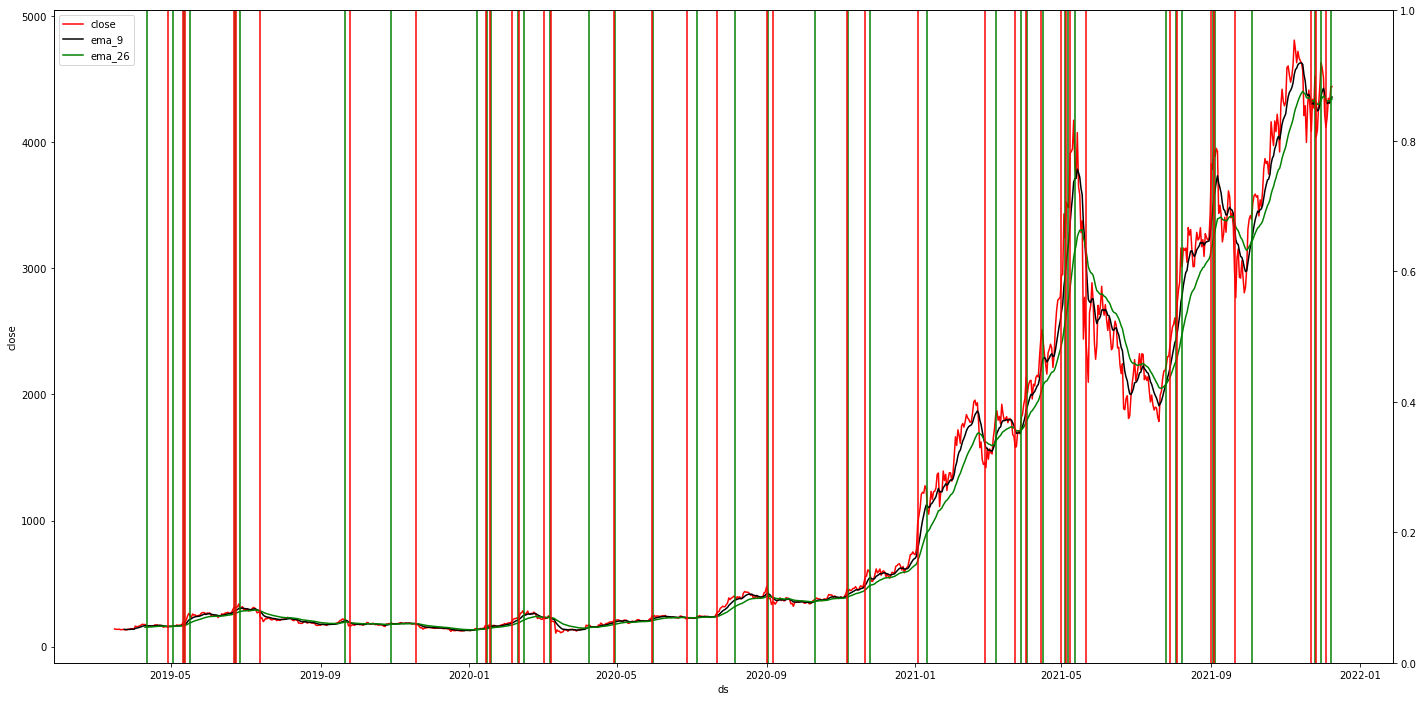

In [46]:
plot_market(data,buys = buys[0],sells = sells[0])

In [49]:
data.to_csv('back_test.csv')